### Домашнее задание №4

In [1]:
!pip install scikit-uplift catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 917 kB/s 
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [2]:
import catboost

catboost.__version__

'1.0.6'

In [16]:
df = pd.read_csv('data.csv')

In [17]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [36]:
%matplotlib inline
import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split


# Чтение данных
df = pd.read_csv('data.csv')

#Переименование столбцов
df.rename(columns={'conversion': 'target'}, inplace=True)
df.rename(columns={'offer': 'treatment'}, inplace=True)

#Изменение признаков столбца 'treatment'
dct = {"treatment": {'No Offer': 0, 'Buy One Get One': 1, 'Discount': 1}}
df = df.replace(dct)

#Разделение выборки на тестовую и тренировочную
df_train = df[['treatment', 'target']]
df_test = df.drop(['treatment', 'target'], axis=1)

#feature engineering
df_features = df_test.copy()
dctf = {"channel": {'Phone': 0, 'Web': 1, 'Multichannel': 2},
         "zip_code": {'Surburban': 0, 'Rural': 1, 'Urban': 2}}
df_features = df_features.replace(dctf)
df_features.fillna(0, inplace=True)

# разбираем примеры на 2 группы : train /val - пока только по индексам клиентов
indices_train = df_train.index  # индексы, для которых знаем результат  
indices_test = df_test.index # индексы, для которых не знаем результат (можем просто дать модели поработать потом)
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123) # разбили известный набор на 2 части

In [38]:
df_test.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
0,10,142.44,1,0,Surburban,0,Phone
1,6,329.08,1,1,Rural,1,Web
2,7,180.65,0,1,Surburban,1,Web
3,9,675.83,1,0,Rural,1,Web
4,2,45.34,1,0,Urban,0,Web


In [39]:
df_train.head()

,treatment,target
0,1,0
1,0,0
2,1,0
3,1,0
4,1,0


In [40]:
df_features.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
0,10,142.44,1,0,0,0,0
1,6,329.08,1,1,1,1,1
2,7,180.65,0,1,0,1,1
3,9,675.83,1,0,1,1,1
4,2,45.34,1,0,2,0,1


Посмотрим на целевое свойство:

In [41]:
df_train.groupby("treatment")['target'].describe()

,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
0,21306.0,0.106167,0.308059,0.0,0.0,0.0,0.0,1.0
1,42694.0,0.167049,0.373024,0.0,0.0,0.0,0.0,1.0


Заведем переменные для работы uplift модели

In [42]:
#данные для обучения
X_train = df_features.loc[indices_learn, :] #признаки о клиенте (в них остались только описания клиентов )
y_train = df_train.loc[indices_learn, 'target'] #целевой признак (те кто сделал правильное действие)
treat_train = df_train.loc[indices_learn, 'treatment']  #те, с кем была коммуникация
#данные для валидации
X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment']
#весь набор целиком
X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment']
#данные из теста (слепые)
X_test = df_features.loc[indices_test, :]
# словарь для записывания результатов
models_results = {
    'approach': [],
    'uplift@30%': []
}

Описание клиента:

In [43]:
X_train.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
53181,8,121.56,0,1,0,0,1
42635,9,617.62,0,1,2,1,0
6296,5,185.62,1,0,1,1,1
41722,1,359.03,0,1,1,0,1
32660,10,139.68,1,0,2,0,1


In [45]:
from sklearn.utils.validation import check_consistent_length
import matplotlib.pyplot as plt

# замена для родной функции из skuplift
def plot_uplift_preds_(trmnt_preds, ctrl_preds, log=False, bins=100):
    """Plot histograms of treatment, control and uplift predictions.

    Args:
        trmnt_preds (1d array-like): Predictions for all observations if they are treatment.
        ctrl_preds (1d array-like): Predictions for all observations if they are control.
        log (bool): Logarithm of source samples. Default is False.
        bins (integer or sequence): Number of histogram bins to be used. Default is 100.
            If an integer is given, bins + 1 bin edges are calculated and returned.
            If bins is a sequence, gives bin edges, including left edge of first bin and right edge of last bin.
            In this case, bins is returned unmodified. Default is 100.

    Returns:
        Object that stores computed values.
    """

    # TODO: Add k as parameter: vertical line on plots
    check_consistent_length(trmnt_preds, ctrl_preds)
  
    if not isinstance(bins, int) or bins <= 0:
        raise ValueError(
            f'Bins should be positive integer. Invalid value for bins: {bins}')

    if log:
        trmnt_preds = np.log(trmnt_preds + 1)
        ctrl_preds = np.log(ctrl_preds + 1)

    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 7))
    axes[0].hist(
        trmnt_preds, bins=bins, alpha=0.3, color='b', label='Treated', histtype='stepfilled')
    axes[0].set_ylabel('Probability hist')
    axes[0].legend()
    axes[0].set_title('Treatment predictions')

    axes[1].hist(
        ctrl_preds, bins=bins, alpha=0.5, color='y', label='Not treated', histtype='stepfilled')
    axes[1].legend()
    axes[1].set_title('Control predictions')

    axes[2].hist(
        trmnt_preds - ctrl_preds, bins=bins, alpha=0.5, color='green', label='Uplift', histtype='stepfilled')
    axes[2].legend()
    axes[2].set_title('Uplift predictions')

    return axes

#### 1. Одна модель с признаком коммуникации
Самое простое и интуитивное решение: модель обучается одновременно на двух группах, при этом бинарный флаг коммуникации выступает в качестве дополнительного признака. Каждый объект из тестовой выборки скорим дважды: с флагом коммуникации равным 1 и равным 0. Вычитая вероятности по каждому наблюдению, получим искомы uplift.

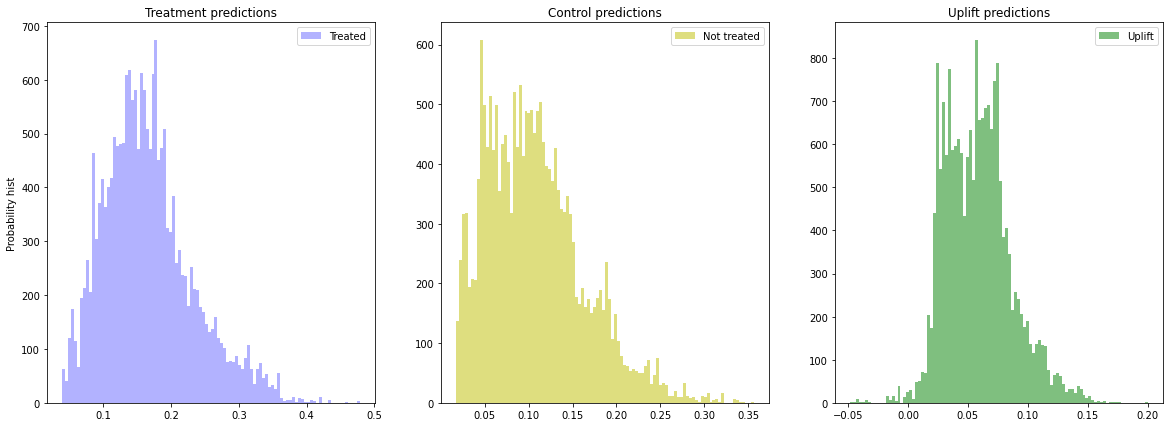

In [56]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds ## в новой версии проблема (беру свой вариант)
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier

N =20000
sm = SoloModel(  CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit( X_train, y_train, treat_train, estimator_fit_params=None)

uplift_sm = sm.predict(X_val)

# размер uplift на топ k процентах выборки
sm_score = uplift_at_k( y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(   sm_trmnt_preds , sm_ctrl_preds, bins=100);#ctrl_preds=

##### Uplift by percentile

Бывает так, что со стороны бизнеса не известно значение порога k и хочется посмотреть, как будет вести себя метрика при разных значениях порога k.

При построении действуем по аналогии с uplift@k:
1. Сортируем по предсказанному значению uplift
2. Делим отсортированные данные на перцентили / децили / бины.
3. В каждом перцентиле отдельно оцениваем uplift как разность между средними значениями целевой переменной в тестовой и контрольной группах.



Результатом этой метрики является таблица или ее визуальное представление в виде графика.

Давайте также для каждого перцентиля рассчитаем следующие показатели:

1. n_treatment - размер целевой (или treatment) группы 
2. n_control - размер контрольной (control) группы
3. response_rate_treatment - среднее значение таргета целевой группы
4. response_rate_control - среднее значение таргета контрольной группы
5. uplift = response_rate_treatment - response_rate_control

Дополнительно добавим расчет среднеквадратичного отклонения для каждой метрики (std_treatment, std_control, std_uplift) для того, чтобы оценивать разброс метрики в каждом перцентиле.

In [61]:
from sklift.metrics import uplift_by_percentile

# uplift by decile, или  uplift by percentile, или uplift by bin.
uplift_by_percentile(y_val, uplift_sm,  treat_val, 
                     strategy='overall', 
                     total=True, std=True, bins=10)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,1301,619,0.231360,0.171244,0.060117,0.011691,0.015142,0.019130
10-20,1312,608,0.190549,0.105263,0.085286,0.010843,0.012446,0.016507
20-30,1264,656,0.178797,0.089939,0.088858,0.010778,0.011170,0.015522
30-40,1267,653,0.167324,0.108729,0.058595,0.010486,0.012182,0.016074
40-50,1266,654,0.161927,0.122324,0.039603,0.010353,0.012813,0.016473
50-60,1330,590,0.140602,0.083051,0.057551,0.009532,0.011361,0.014830
60-70,1251,669,0.153477,0.092676,0.060802,0.010191,0.011211,0.015151
70-80,1248,672,0.144231,0.087798,0.056433,0.009945,0.010917,0.014768
80-90,1266,654,0.155608,0.094801,0.060807,0.010188,0.011455,0.015330


### 2 Трансформация классов
Достаточно интересный и математически подтвержденный подход к построению модели, представленный еще в 2012 году. Метод заключается в прогнозировании немного измененного таргета:

$$Z_i = Y_i \cdot W_i + (1 - Y_i) \cdot (1 - W_i),$$
где
- $Z_i$ - новая целевая переменная $i$-того клиента
- $Y_i$ - целевая переменная $i$-того клиента
- $W_i$ - флаг коммуникации $i$-того клиента



Другими словами:

$$
Z_i = \begin{cases}
    1, & \mbox{if } W_i = 1 \mbox{ and } Y_i = 1 \\
    1, & \mbox{if } W_i = 0 \mbox{ and } Y_i = 0 \\
    0, & \mbox{otherwise}
   \end{cases}
$$

In [62]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params=None)

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

In [65]:
uplift_by_percentile(y_val, uplift_ct,  treat_val, 
                     strategy='overall', 
                     total=True, std=True, bins=10)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,1284,636,0.249221,0.169811,0.079410,0.012072,0.014888,0.019167
10-20,1293,627,0.211910,0.153110,0.058800,0.011365,0.014381,0.018329
20-30,1291,629,0.194423,0.092210,0.102213,0.011014,0.011536,0.015950
30-40,1278,642,0.183099,0.104361,0.078737,0.010818,0.012066,0.016206
40-50,1314,606,0.133942,0.095710,0.038233,0.009396,0.011951,0.015202
50-60,1251,669,0.177458,0.115097,0.062361,0.010802,0.012339,0.016399
60-70,1278,642,0.122848,0.079439,0.043409,0.009182,0.010673,0.014079
70-80,1266,654,0.131912,0.077982,0.053930,0.009511,0.010485,0.014156
80-90,1259,661,0.136616,0.084720,0.051896,0.009679,0.010831,0.014526


#### 3. Две независимые модели
Как понятно из названия, подход заключается в моделировании условных вероятностей тестовой и контрольной групп отдельно. В статьях утверждается, что такой подход достаточно слабый, так как обе модели фокусируются на прогнозировании результата отдельно и поэтому могут пропустить "более слабые" различия в выборках.

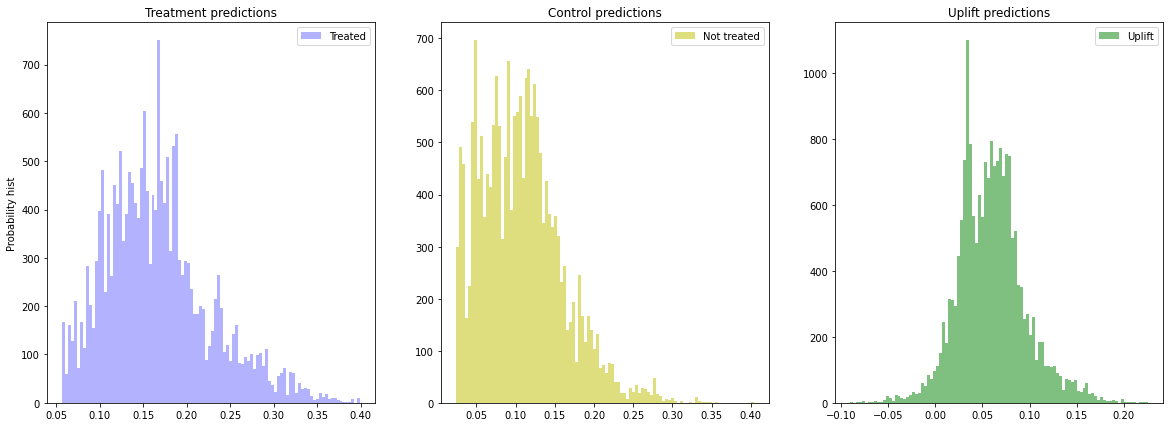

In [66]:
from sklift.models import TwoModels


tm = TwoModels(     
    estimator_trmnt=CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)   

# method ='ddr_control' ('ddr_treatment') - зависимые модели
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params=None, 
    estimator_ctrl_fit_params=None
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds_(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [68]:
uplift_by_percentile(y_val, uplift_tm,  treat_val, 
                     strategy='overall', 
                     total=True, std=True, bins=10)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,1289,631,0.238169,0.152139,0.086030,0.011864,0.014298,0.018579
10-20,1251,669,0.192646,0.112108,0.080538,0.011150,0.012198,0.016526
20-30,1274,646,0.164050,0.091331,0.072719,0.010375,0.011334,0.015366
30-40,1300,620,0.138462,0.088710,0.049752,0.009579,0.011419,0.014905
40-50,1268,652,0.151420,0.102761,0.048659,0.010066,0.011892,0.015580
50-60,1300,620,0.179231,0.114516,0.064715,0.010638,0.012789,0.016635
60-70,1278,642,0.138498,0.107477,0.031021,0.009662,0.012224,0.015581
70-80,1272,648,0.130503,0.086420,0.044083,0.009445,0.011038,0.014527
80-90,1298,622,0.145609,0.077170,0.068438,0.009790,0.010700,0.014503


Посмотрим на результаты

In [1]:
models_score = [["модель с признаком коммуникации", 0.060117, 0.085286],
         ["модель с трансформацией таргета", 0.079410, 0.058800],
         ["две независимые модели", 0.086030, 0.080538]]

In [70]:
pd.DataFrame(models_score, columns=["Модель", "uplift@10%","uplift@20%"])

,Модель,uplift@10%,uplift@20%
0,модель с признаком коммуникации,0.060117,0.085286
1,модель с трансформацией таргета,0.079410,0.058800
2,две независимые модели,0.086030,0.080538


#### 4. Модель UpliftTreeClassifie

In [73]:
!pip install causalml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 406 kB 14.5 MB/s 
     |████████████████████████████████| 569 kB 51.6 MB/s 
     |████████████████████████████████| 1.8 MB 60.3 MB/s 
     |████████████████████████████████| 718 kB 69.1 MB/s 
  Created wheel for causalml: filename=causalml-0.12.3-cp37-cp37m-linux_x86_64.whl size=1053942 sha256=699bb34e0145f541a190b19cb50cf87a000ac6b5d50d4c51933c6301ca2a3db0
  Stored in directory: /root/.cache/pip/wheels/d7/5e/47/4e965cf8e87c6c10cd7361d910acccd08a1de459f25d55fd23
Successfully built causalml


In [75]:
X_train_tree = X_train
features = [col for col in X_train_tree]

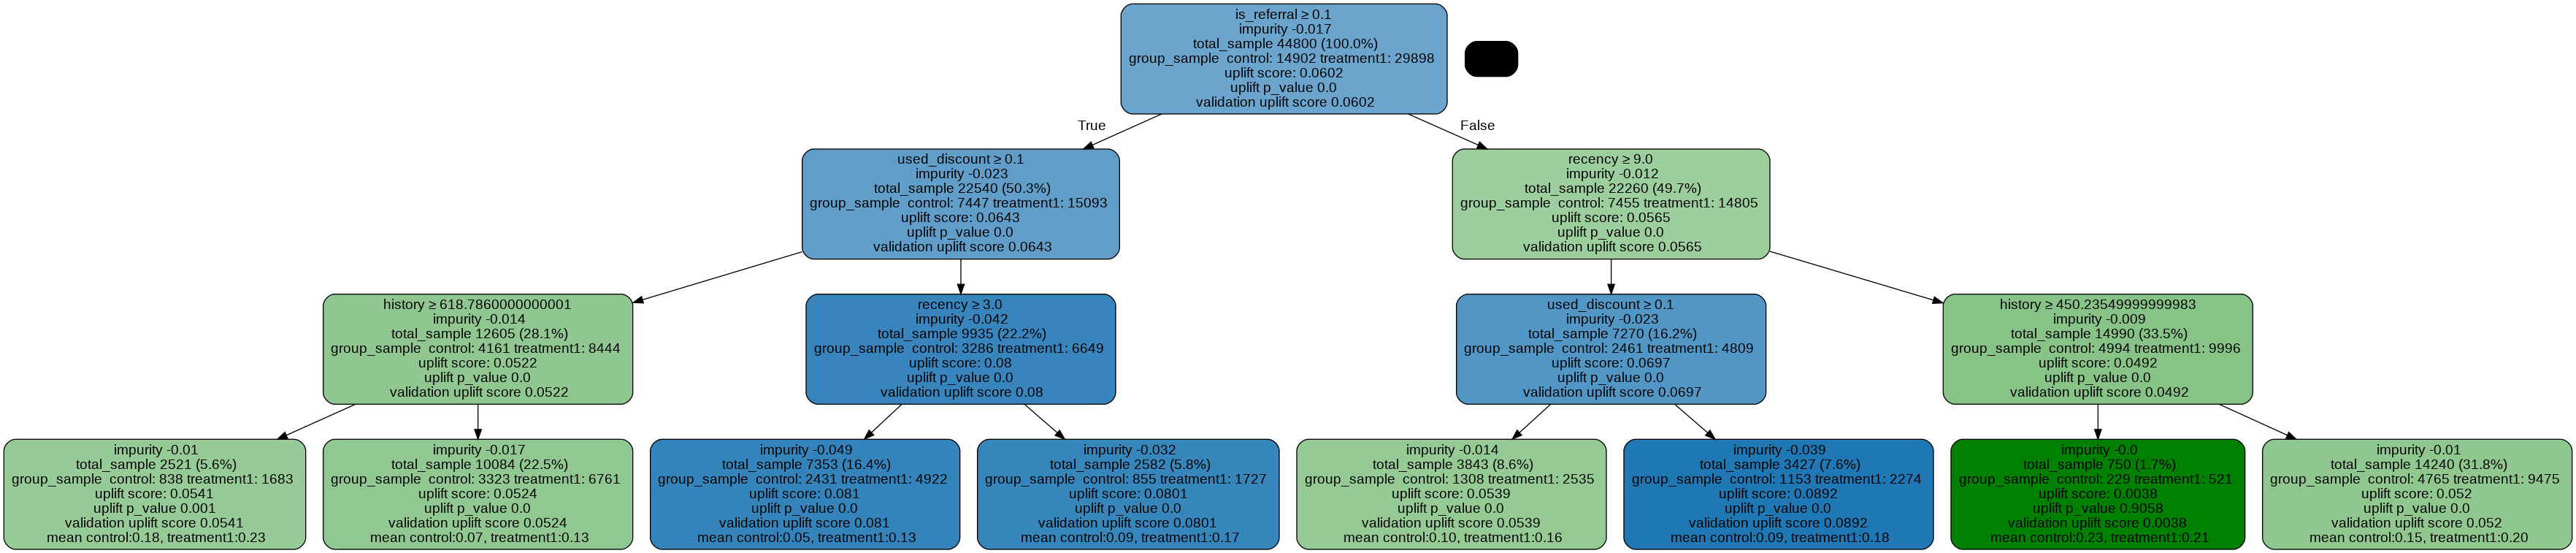

In [76]:
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=4, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

In [77]:
from IPython.display import Image, display

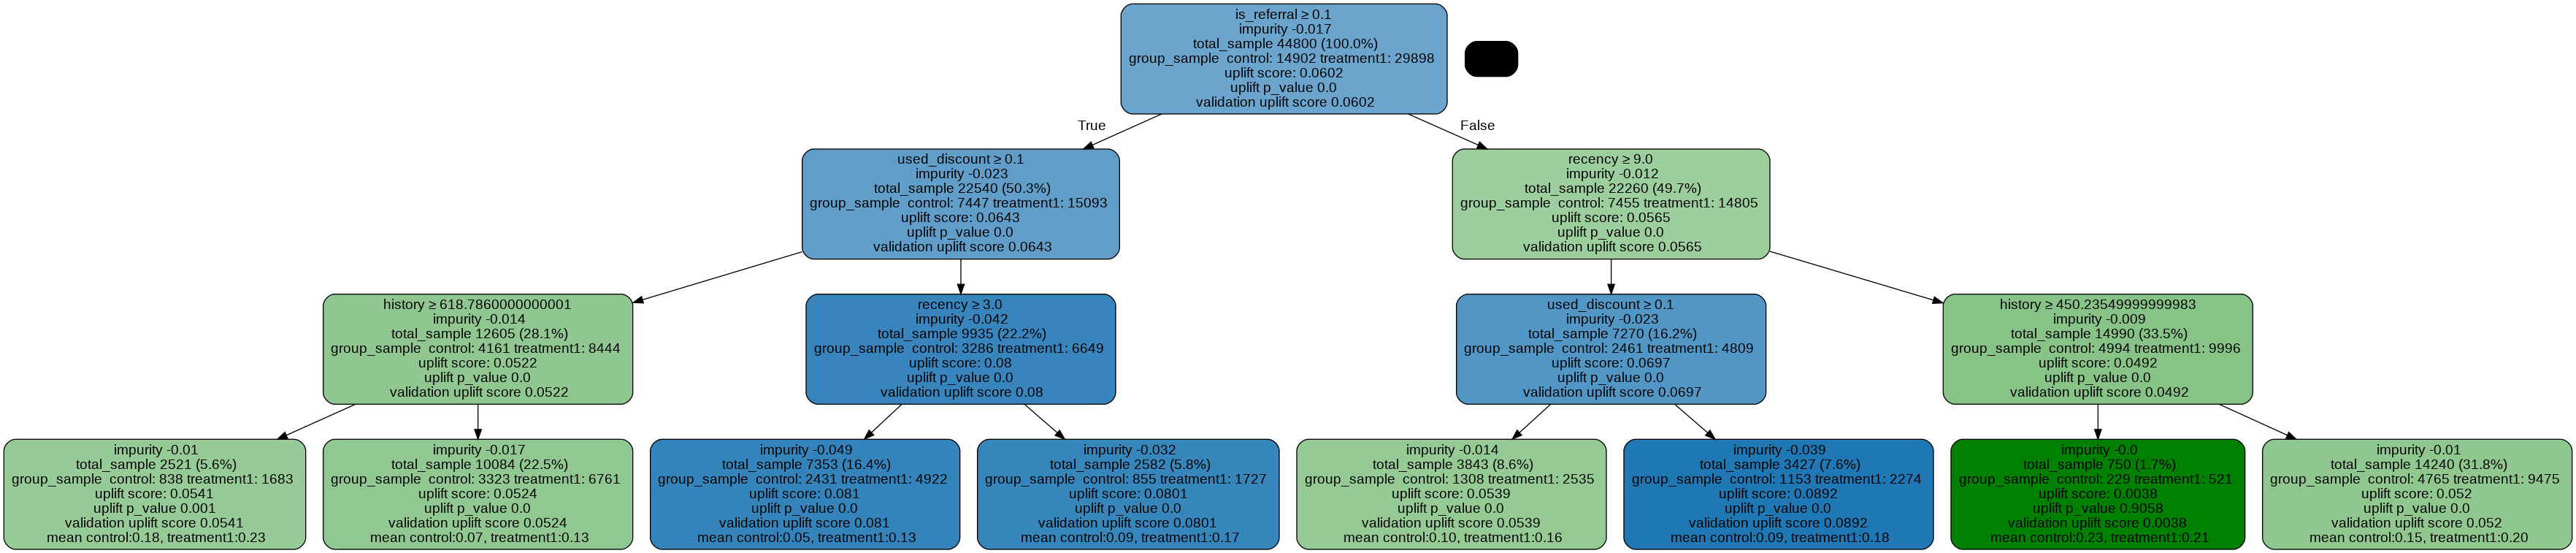

In [78]:

display(Image(graph.create_png()))